In [113]:
%matplotlib inline
import os
import imp

import numpy as np
import pandas as pd
import xarray as xr
from IPython import display

import matplotlib
import matplotlib.pyplot as plt

import climatools.viz as climaviz
import climatools.io.cesm as climaio
import climatools.units as climaunits
import climatools.aerosol.aerosol as climaaerosol

## Debug: pressure inputs in RRTMG column model


In the input to RRTMG column model, pressures for atmosphere boundaries  need to be provided by the user.  In addition to these, two pressures, one for the surface (HBOUND) and one for the top of the atmosphere (HTOA), and the altitude for the lowest atmosphere boundary (ZM(0)), also need to be provided by the user.  

However, it is not clear how HBOUND, HTOA and ZM(0) should be chosen, because from experience, not all combinations of atmosphere boundary pressures, HBOUND, HTOA and ZM(0) allow RRTMG to complete, and could run into one of the following errors:

    BOUNDARIES ARE OUTSIDE THE RANGE OF THE ATMOSPHERE
    BOUNDARY = XXX, ATMOSPHERE = XXX
    RESET BOUNDARY GT THAN ATMOSPHERE
    COMPUTED ALTITUDE VALUE OF H2 IS NEGATIVE
    
or

    BOUNDARIES ARE OUTSIDE THE RANGE OF THE ATMOSPHERE
    BOUNDARY = XXX, ATMOSPHERE = XXX
    RESET BOUNDARY GT THAN ATMOSPHERE
    BOUNDARIES OUTSIDE OF ATMOS
    

This notebook sets out to find out why these errors are raised.


In [125]:
class PressureCase(object):
    
    def __init__(self, 
                 ipressure=None, 
                 ialt=None,
                 hbound=None, htoa=None):
        self._ipressure = ipressure
        self._ialt = ialt
        self._hbound = hbound
        self._htoa = htoa
    
    def ipressure(self):
        return self._ipressure
    
    def ialt(self):
        return self._ialt
    
    def hbound(self):
        return self._hbound
    
    def htoa(self):
        return self._htoa
    

def case_1():
    '''
    CAM history.  Doesn't work.
    '''
    dir_camhist = '/nuwa_cluster/home/jackyu/radiation/radiation_notebooks/rrtmg_aerosol'
    file_camhist = 'f19_g16.B1850.std.cam2.h0.0001-06.nc'
    path_camhist = os.path.join(dir_camhist, file_camhist)
    
    ds = climaio.load_camhistory(path_camhist)
    ds = climaunits.hybrid2mbar(ds)
    
    ds = climaaerosol.interp_layers2levels(ds, vars=['Z3'])
    
    surface = dict(time=0, lat=0, lon=0)
    
    ipressure = ds['ipressure'].isel(**surface).to_pandas()
    ipressure.index = range(len(ipressure))[::-1]
    
    zm0 = ds['PHIS'].isel(**surface).values / 9.8 * 1e-3
    ialt = pd.Series(zm0 * np.ones(ipressure.shape))
    ialt.index = range(len(ialt))[::-1]
    
    case = PressureCase(ipressure=ipressure,
                        ialt=ialt,
                        hbound=670, htoa=2.3)
    return case


def case_2():
    '''
    Prof. Chou's mid-latitude summer 71 levels.  Works.

    HBOUND = 1013
    HTOA = 1e-3
    '''
    hbound, htoa = 1013, 1e-3
    
    dir_examples = '/nuwa_cluster/home/jackyu/radiation/rrtmg/SW/examples'
    file_atmpro = 'mls_71lvls_H2O/atmpro_mls70.h5'
    path_atmpro = os.path.join(dir_examples, file_atmpro)
    
    with pd.HDFStore(path_atmpro) as store:
        atmpro = store['atmpro']
    
    case = PressureCase(ipressure=atmpro['pressure'],
                        ialt=atmpro['altitude'],
                        hbound=hbound, htoa=htoa)
    return case


def case_3():
    '''
    Prof. Chou's mid-latitude summer 36/71 levels.  Works.

    The 36 levels cover a range close to that covered by the 31 levels 
    of CAM history.

    HBOUND = 656
    HTOA = 2.2
    '''    
    hbound, htoa = 656, 2.2
    
    dir_examples = '/nuwa_cluster/home/jackyu/radiation/rrtmg/SW/examples'
    file_atmpro = 'mls_71lvls_H2O_subset/atmpro_mls70.h5'
    path_atmpro = os.path.join(dir_examples, file_atmpro)
    
    with pd.HDFStore(path_atmpro) as store:
        atmpro = store['atmpro']

    case = PressureCase(ipressure=atmpro['pressure'],
                        ialt=atmpro['altitude'],
                        hbound=hbound, htoa=htoa)
    return case

In [126]:
def plot_case_1_case_2():
    cases = [case_1(), case_3()]
    outcomes = ['Does not work.', 'Works']
    
    fig, axs = plt.subplots(nrows=1, ncols=2,
                            figsize=(14, 7),
                            sharey=True)
    
    for ax, case, outcome in zip(axs, cases, outcomes):
        case.ipressure().plot(ax=ax, 
                              linestyle='None', marker='o',
                              title='{} (ZM(0) = {:8.4f} km)'\
                              .format(outcome, case.ialt()[0]),
                              logy=True,
                              logx=False,
                              grid=True)
                
        ax.set_xlabel('level index')
        
        ax.axhline(y=case.hbound(), color='r')        
        ax.axhline(y=case.htoa(), color='r')
        
        ax.set_ylabel('pressure [mb]')

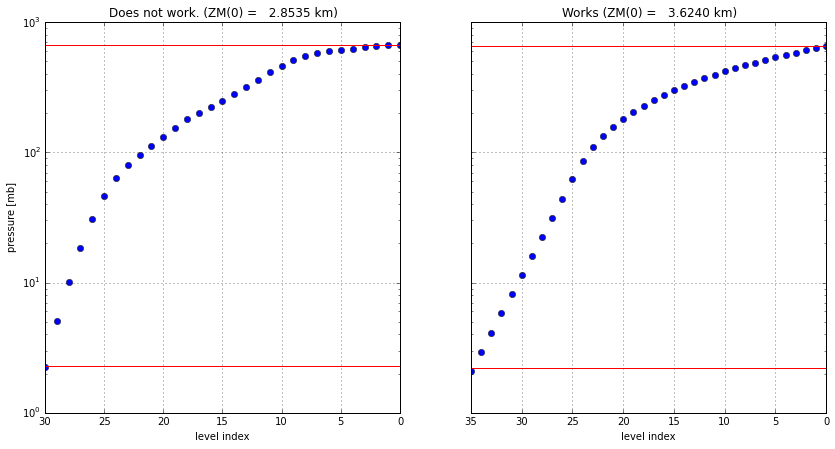

In [127]:
plot_case_1_case_2()

In the above figure are plots of boundary index versus pressure at atmosphere boundary.  

In the left panel, the blue dots are CAM history's boundary pressures that have been computed from `hyai`, `hybi`, `PS` and `P0`.  The red lines indicate the HBOUND and HTOA chosen, while the altitude for the first atmosphere boundary is set to 2.85 km; this value is obtained by first linearly interpolating `Z3` to the atmosphere boundaries and then selecting the value of the lowest boundary.  

In the right panel, the blue dots are the boundary pressures from Prof. Chou's "mls75" atmosphere profile within a pressure range as close to that of the CAM history as possible; there are 36 boundaries.  The red lines are HBOUND and HTOA.  The altitude for the first atmosphere boundary is set to 3.62 km; this values is obtained by first applying the hydrostatic equation to find altitudes of the original 76 boundaries, with the altitude of the lowest set to 0 km, then selecting the altitude of the lowest boundary amongst the selected 36 boundaries.

For the case that does not work above, the error message is:

     BOUNDARIES ARE OUTSIDE THE RANGE OF THE ATMOSPHERE
     BOUNDARY =       2.85 ATMOSPHERE =      2.85
     RESET BOUNDARY GT THAN ATMOSPHERE
     BOUNDARIES OUTSIDE OF ATMOS
     
Note that the profile in the left panel is close to the pole, while it is at mid-latitude summer in the right panel.

In [128]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')